# Hierarchical agglomerative clustering (Above-phoneme)

### Collect training features

In [9]:
import numpy as np
import random
import os, sys
import matplotlib.pyplot as plt
import warnings
from lib.esn import ESN
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

path = '../../data/'
fc = DataLoader(path)

dr = []
speakers = []
XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features, labels, _ = fc.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


In [10]:
from dataset.data_helpers import *

selected_labels = None
#selected_labels = ["aa", "b", "s", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh", "er", "ey", "ix", "aw", "axr", "l", "oy", "r", "y"]

phonemes, features, labels = filter_data(features, labels, selected_labels=selected_labels, limit=None)
group = group_by_labels(features, labels)
n_samples = len(features)
n_classes = len(phonemes)

print(f"{str(n_classes)} phonemes: {phonemes}")

Filtered to 177080 samples of shape (10, 14)
39 phonemes: ['h#', 'w', 'ih', 's', 'ah', 'ch', 'n', 'ae', 't', 'v', 'r', 'f', 'y', 'uw', 'sh', 'l', 'b', 'iy', 'aa', 'd', 'eh', 'p', 'z', 'ey', 'dx', 'ay', 'ng', 'k', 'dh', 'er', 'm', 'jh', 'g', 'ow', 'aw', 'hh', 'uh', 'oy', 'th']


In [11]:
# init reservoir

esn_params = {
    "in_dim": n_mels,
    "out_dim": n_mels,
    "N": 10,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5,
    "weights": .1
}

esn = ESN(esn_params)

In [ ]:
from lib.experiment_helpers import *

aperture = "auto"
normalize = True
Cs = compute_Cs(group=group, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ)

- computing conceptors


In [ ]:
from lib.clustering_metrics import get_heat_map
from lib.clustering_helpers import *

save = False

hm_filename = str(selected_labels)+path_option+XorZ + str(aperture) + str(esn.esn_params) + str(len(group.keys())) + str(len(list(group.values())[0])) + "heatmap"

hm = None
if save:
    hm = try_reading_from_cache(hm_filename)
if hm is None:
    print("- computing heatmap")
    hm = get_heat_map(Cs, similarity_c)
    save_to_cache(hm_filename, hm)
    print("--- Done")

### Average linkage and plotting of its results

In [ ]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

distArray = ssd.squareform(hm)
#distArray = 1-distArray/np.max(distArray)
distArray = -np.log(distArray)
link = sc.linkage(distArray, method='average', optimal_ordering=False)

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 9))

D = sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

plt.title("Average Linkage on Phoneme Conceptors using Herbert's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=-log(sim(C^1,C^2))$",fontsize=15)
plt.show()

### Plot Heatmap

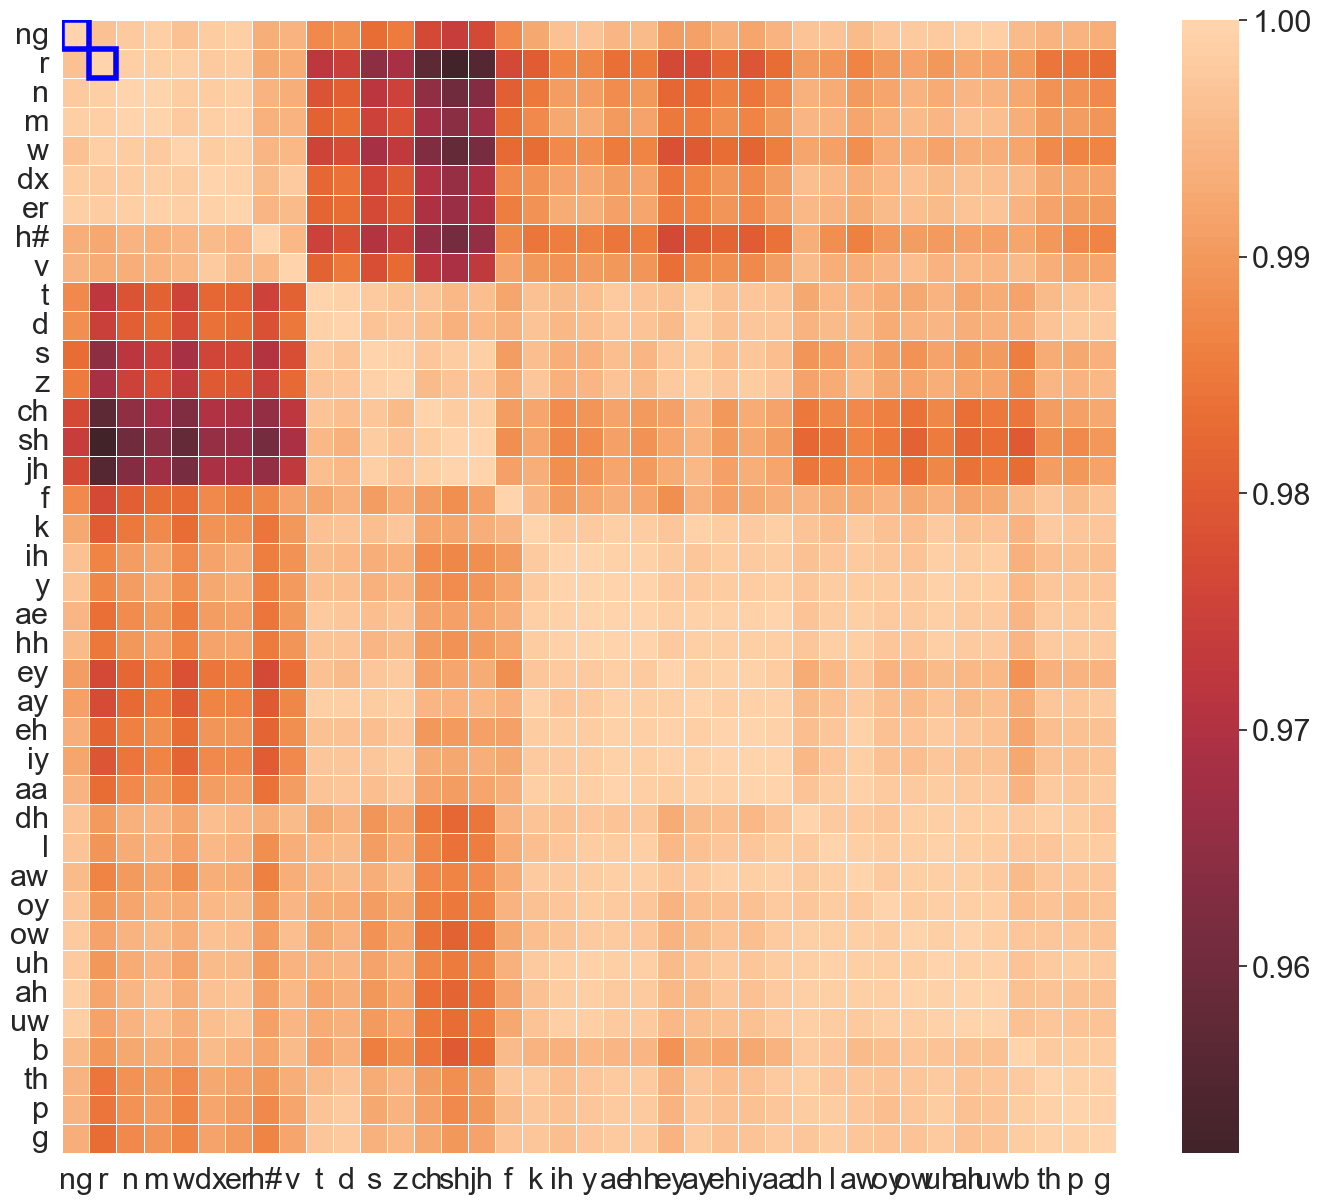

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

np.fill_diagonal(hm, 1)

labs = D["ivl"]
custom_labs = []
reorder = [ phonemes.index(lab) for lab in labs]
hm = hm[reorder,:]
hm = hm[:,reorder]

plt.figure(figsize=(17,15),dpi=100)
sns.set_theme()
sns.set(font_scale=2)

ax_hm = sns.heatmap(hm, xticklabels=labs, yticklabels=labs, linewidths=.5, center=np.mean(hm)-.05)
plt.rc('xtick', labelsize='20')    # fontsize of the tick labels
plt.rc('ytick', labelsize='20')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Adding coloring to phonetic groups
recs = [
    [0,1],
    [1,1]
]
for rec in recs:
    ax_hm.add_patch(
         patches.Rectangle(
             (rec[0], rec[0]),
             rec[1], rec[1],
             edgecolor='blue',
             fill=False,
             lw=4
         )
    )

plt.show()

 # Old -  May be deletable

In [8]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

for i in range(heat_map.shape[0]):
    heat_map[i,i] = 0
distArray = ssd.squareform(heat_map)

if dist_fun == 'cos':
    distances = 1-distArray/np.max(distArray)
else:
    distances = distArray/np.max(distArray)

link = sc.linkage(distances, method='average', optimal_ordering=False)

# Plot dendrogram
plt.figure(dpi=120)
plt.title("Dendrograms")  
# Create dendrogram
sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

#plt.title("Average Linkage on Phoneme Conceptors using Herbert's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=||p^1-p^2||$",fontsize=15)
plt.show()

NameError: name 'heat_map' is not defined

In [ ]:
heat_map = np.zeros((len(phonemes),len(phonemes)))

for i, samples in enumerate(group.values()):
    print("It: ",i)
    if XorZ == "X":
        X = np.array([])
        for sample in samples:
            x,_ = esn.run_X(sample.T,0,sample.shape[0])
            X = np.hstack((X, x)) if X.size else x
        es = evidences_for_Cs(x,Cs_above,Ns_above)
    es = [ np.sum(p) for p in es ]
    es = np.array(es)
    heat_map[i,:] = np.array(es.T)
    heat_map[:,i] = np.array(es)

print(heat_map)

In [ ]:
for i in range(heat_map.shape[0]):
    heat_map[i,i] = 0
distArray = ssd.squareform(heat_map)

link = sc.linkage(1-distArray/np.max(distArray), method='average', optimal_ordering=False)

# Plot dendrogram
plt.figure(figsize=(10, 7))

sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

plt.title("Average Linkage on Phoneme Conceptors using Herbert's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=1-\frac{sim(C^1,C^2)}{max_{i,j}sim(C^i,C^j)}$",fontsize=15)
plt.show()

In [ ]:
save = True
dist_fun = "cos"
hm_filename = "_5_40_1100_False_14_False_False_10_hm_cos"

if save and os.path.exists('./cache/working/'+hm_filename+'.pkl'):
    print("- from file")
    fp = open('./cache/working/'+hm_filename+'.pkl','rb')
    heat_map = pkl.load(fp)
    fp.close()
    print("--- Done")
else:
    print("- computing heatmap")
    heat_map = np.zeros((len(phonemes),len(phonemes)))

    for x in range(len(phonemes)):
        for y in range(0, x+1):
            sim = similarity_c(Cs[x], Cs[y])
            heat_map[x,y] = sim
            heat_map[y,x] = sim
    if save:
        fp = open("./cache/working/"+hm_filename+".pkl",'wb')
        pkl.dump(heat_map,fp)
        fp.close()
    print("--- Done")

In [ ]:
coll = []
hm = heat_map.copy()

for t in range(len(phonemes)**2):
    max = 0
    maxx = 0
    maxy = 0
    for x in range(hm.shape[0]):
        for y in range(0, x):
            if max < hm[x,y]:
                max = hm[x,y]
                maxx = x
                maxy = y
    coll.append((phonemes[maxx],phonemes[maxy],hm[maxx,maxy]))
    hm[maxx, maxy] = 0

for x,y,val in coll:
    print(x," ",y," ",val)

In [ ]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

for i in range(heat_map.shape[0]):
    heat_map[i,i] = 0
distArray = ssd.squareform(heat_map)

if dist_fun == 'cos':
    distances = 1-distArray/np.max(distArray)
elif dist_fun == 'eucl':
    distances = distArray/np.max(distArray)

link = sc.linkage(distances, method='average', optimal_ordering=False)

# Plot dendrogram
plt.figure(dpi=120)
plt.title("Dendrograms")
# Create dendrogram
sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

#plt.title("Average Linkage on Phoneme Conceptors using Herbert's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=1-\frac{sim(C^1,C^2)}{max_{i,j}sim(C^i,C^j)}$",fontsize=15)
plt.show()

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
plt.figure(figsize=(17,15),dpi=200)
sns.set_theme()

ticklabels=phonemes
print(phonemes)
sns.set(font_scale=2)
labs = ['dh','v',"h#",'k','t','p','hh','g','d','b','dx','ah','ih','uw','ey','iy','eh','ae','ay','ow','aa','er','r','l','w','ng','n','m','y','z','s','sh','jh','f']
labs = ['g','d',"b",'dx','hh','dh','hh','g','d','b','dx','ah','ih','uw','ey','iy','eh','ae','ay','ow','aa','er','r','l','w','ng','n','m','y','z','s','sh','jh','f']

print(len(labs),len(phonemes))
reorder = [ phonemes.index(lab) for lab in labs]
hm = heat_map[reorder,:]
hm = hm[:,reorder]
ax = sns.heatmap(hm, xticklabels=labs, yticklabels=labs, linewidths=.5, center=np.mean(heat_map)-.06)

plt.rc('xtick', labelsize='20')    # fontsize of the tick labels
plt.rc('ytick', labelsize='20')

recs = [
    [1,1]

]

for rec in recs:
    ax.add_patch(
         patches.Rectangle(
             (rec[0], rec[0]),
             rec[1],
             rec[1],
             edgecolor='blue',
             fill=False,
             lw=5
         ) )

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.show()